<a href="https://colab.research.google.com/github/Belashov641618/DNN/blob/main/collab/Incoherent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
!git clone https://github.com/Belashov641618/DNN.git

Cloning into 'DNN'...
remote: Enumerating objects: 625, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 625 (delta 107), reused 156 (delta 68), pack-reused 400
Receiving objects: 100% (625/625), 24.21 MiB | 26.41 MiB/s, done.
Resolving deltas: 100% (315/315), done.


In [8]:
!git pull

Already up to date.


In [3]:
!dir
from google.colab import files
files.view('/content/DNN')
!dir

DNN  sample_data


<IPython.core.display.Javascript object>

DNN  sample_data


In [19]:
%cd DNN
import sys, os
sys.path.append(os.path.abspath('src'))

[Errno 2] No such file or directory: 'DNN'
/content/DNN


In [5]:
!pip install belashovplot
from belashovplot.belashovplot import DefaultFont, DefaultBigHeader, DefaultHeader, DefaultDefault, DefaultCaption, DefaultSmallCaption
DefaultFont['font'] = 'DejaVu Sans'
for Font in [DefaultBigHeader, DefaultHeader, DefaultDefault, DefaultCaption, DefaultSmallCaption]:
  Font.Font = 'DejaVu Sans'

  Preparing metadata (setup.py) ... done
  Created wheel for belashovplot: filename=belashovplot-1.0-py3-none-any.whl size=12758 sha256=53f74ab3442caa383c8603bd810c7f5aee1d5502b01d5792792c6dd5692d2a6a
  Stored in directory: /root/.cache/pip/wheels/55/7b/e2/e5bf08c4c48d0989afbcb220497fa4bb6805a32f6c7826eece
Successfully built belashovplot


In [6]:
import torch
import numpy

In [20]:
from src.modules import layers
from src.utilities import decimal

In [55]:
torch.cuda.empty_cache()

pixels = 1023
wavelength = 532*decimal.nm
distance = 30.0*decimal.cm
length = pixels * wavelength * 1
samples = 500
padding = int(pixels*0.5)
focus = pixels*length*length / ((pixels*pixels - 1) * wavelength)
# 1/f = 1/a + 1/b -> 1/b = 1/f - 1/a -> b = af / (a - f)
distance_b = distance * focus / abs(distance - focus)

distance = focus
distance_b = focus

print(distance, distance_b, focus)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
propagator = layers.FourierPropagationLayer(500.0*decimal.nm, 1.0, length, pixels, 1, distance, length).to(device)
propagator_b = layers.FourierPropagationLayer(500.0*decimal.nm, 1.0, length, pixels, 1, distance_b, length).to(device)
lens = layers.LensLayer(focus, wavelength, length, pixels, 1).to(device)
def model(data:torch.Tensor):
    return propagator_b(lens(propagator(data)))

from src.utilities.UniversalTestsAndOther import GenerateSingleUnscaledSampleMNIST
from torchvision.transforms.functional import resize, pad
from torchvision.transforms import InterpolationMode

with torch.no_grad():
  image = pad(resize(GenerateSingleUnscaledSampleMNIST(True).abs(), size=[pixels-2*padding, pixels-2*padding], interpolation=InterpolationMode.BILINEAR, antialias=True), [padding]*4, 0.)
  # image = torch.zeros_like(image)
  # s = 5
  # image[:,:, int(pixels/2)-s:int(pixels/2)+s, int(pixels/2)-s:int(pixels/2)+s] = 1.0
  coherent = image.clone().to(torch.complex64).to(device)
  incoherent = coherent.clone().expand(samples, 1, pixels, pixels) * torch.exp(2j*torch.pi*torch.rand(samples, 1, pixels, pixels, device=device, dtype=torch.float32))

  coherent_result = model(coherent)

  try_again = True
  split = 16
  while try_again:
    try:
      incoherent_results = torch.zeros_like(coherent_result, dtype=torch.float32)
      for part in torch.chunk(incoherent, split, dim=0):
          incoherent_results += torch.mean(torch.abs(model(part)), dim=0)
      incoherent_results /= split
      try_again = False
    except RuntimeError as e:
      split *= 2
      print(f'Split: {split}')

  M = 200
  Na = int(M*distance/(distance+distance_b))
  Nb = int(M*distance_b/(distance+distance_b))
  cut = torch.zeros(Na + Nb, pixels)
  distances = numpy.linspace(0, distance, Na+1)[:-1]
  for i, distance_ in enumerate(distances):
    coherent_ = propagator(coherent)
    propagator.distance = distance_
    cut[i] = torch.abs(coherent_.squeeze()[int(pixels/2)].cpu())
  coherent_ = lens(coherent_)
  distances = numpy.linspace(0, distance_b, Nb)
  for i, distance_ in enumerate(distances, start=Na):
    propagator_b.distance = distance_
    cut[i] = torch.abs(propagator_b(coherent_).squeeze()[int(pixels/2)].cpu())

  coherent = coherent.squeeze().cpu()
  coherent_result = coherent_result.squeeze().cpu()
  incoherent_results = incoherent_results.squeeze().cpu()
  cut = cut.squeeze().cpu()

0.0005442365200395976 0.0005442365200395976 0.0005442365200395976
Split: 32
Split: 64


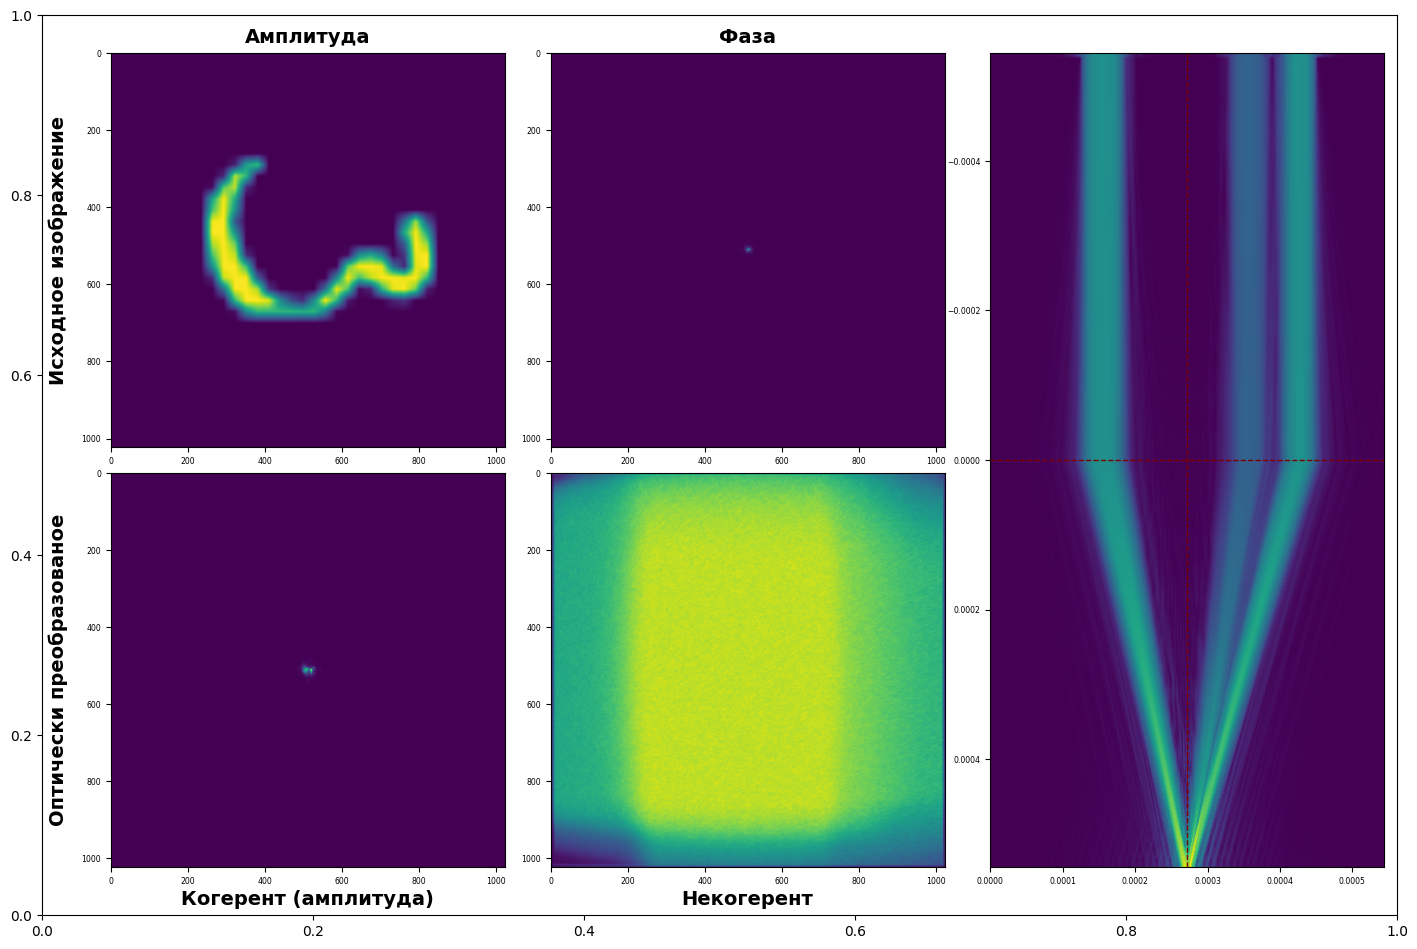

In [56]:
from belashovplot import TiledPlot

plot = TiledPlot(16,9)
plot.FontLibrary.MultiplyFontSize(0.7)

plot.description.row.left('Исходное изображение', 0)
plot.description.row.left('Оптически преобразованое', 1)
plot.description.column.top('Амплитуда', 0)
plot.description.column.top('Фаза', 1)
plot.description.column.bottom('Когерент (амплитуда)', 0)
plot.description.column.bottom('Некогерент', 1)

kwargs = {'aspect':'auto', 'cmap':'viridis'}

axes = plot.axes.add(0,0)
axes.imshow(torch.abs(coherent), **kwargs)

axes = plot.axes.add(1,0)
axes.imshow(torch.abs(torch.fft.fftshift(torch.fft.fft2(coherent))), **kwargs)

axes = plot.axes.add(0,1)
axes.imshow(torch.abs(coherent_result), **kwargs)

axes = plot.axes.add(1,1)
axes.imshow(incoherent_results, **kwargs)

axes = plot.axes.add((2,0), (2, 1))
axes.imshow(torch.log10(cut+0.1), **kwargs, extent=[0, length, distance_b, -distance])
axes.axvline(length/2, (distance_b-focus)/(distance + distance_b), (distance_b+focus)/(distance + distance_b), color='maroon', linestyle='--', linewidth=1.0)
axes.axhline(0, color='maroon', linestyle='--', linewidth=1.0)

plot.show()

In [36]:
torch.cuda.empty_cache()